### Import Package

In [768]:
import pandas as pd
import quantstats as qs
import numpy as np
import talib
import ray
import random 

from core.system import *
from core.operation import *
from fredapi import Fred
from pandas.tseries.offsets import BDay

import warnings

warnings.filterwarnings('ignore')

### Data

In [769]:
def create_multi_index(factor_data, stock):
    factor_values = pd.concat([factor_data] * len(stock), ignore_index=True).values
    multi_index = pd.MultiIndex.from_product([stock, factor_data.index])
    multi_index_factor = pd.DataFrame(factor_values, columns=factor_data.columns, index=multi_index)
    multi_index_factor.index = multi_index_factor.index.set_names(['ticker', 'date'])
    return multi_index_factor

In [770]:
live = True
start = '2005-01-01'
current_date = date.today().strftime('%Y-%m-%d')

In [771]:
sp500_tickers = [
    "AAPL",  # Apple Inc.
    "MSFT",  # Microsoft Corporation
    "JNJ",   # Johnson & Johnson
    "WMT",   # Walmart Inc.
    "PG",    # Procter & Gamble
    "JPM",   # JPMorgan Chase & Co.
    "V",     # Visa Inc.
    "UNH",   # UnitedHealth Group
    "INTC",  # Intel Corporation
    "T",     # AT&T Inc.
    "CSCO",  # Cisco Systems
    "PFE",   # Pfizer Inc.
    "HD",    # Home Depot
    "BA",    # Boeing Company
    "XOM",   # Exxon Mobil Corporation
    "CVX",   # Chevron Corporation
    "KO",    # Coca-Cola Company
    "MCD",   # McDonald's Corp
    "GS",    # Goldman Sachs Group
    "MMM",   # 3M Company
    "AMZN",  # Amazon.com, Inc.
    "BRK.B", # Berkshire Hathaway Inc.
    "GE",    # General Electric Company
    "IBM",   # International Business Machines Corporation
    "DIS"    # Walt Disney Company
]

price_data = get_data_fmp(ticker_list=sp500_tickers, start=start, current_date=current_date)
price_data['Close'] = price_data['Adj Close']

Fetching data: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:23<00:00,  1.05ticker/s]


In [772]:
rf = pd.read_parquet(get_parquet(live) / 'data_rf.parquet.brotli')
rf = rf.ffill()
rf = create_multi_index(rf, sp500_tickers)
rf.index.names = ['ticker', 'date']

In [773]:
price_data = price_data.merge(rf, left_index=True, right_index=True, how='left')
price_data['RF'] = price_data.groupby('ticker')['RF'].ffill()

### Create Metrics

In [952]:
def compound_returns(x, window):
    return (1 + x).rolling(window).apply(lambda y: y.prod(), raw=True) - 1

### Strategy

In [1181]:
# Params
lookback_period = 252*2
hold_period = 126

In [1182]:
# Create returns and get compound excess return
daily_data = create_return(price_data, [1])
daily_data['cum_ret'] =  daily_data.groupby('ticker')['RET_01'].transform(compound_returns, lookback_period)
daily_data['cum_ret_excess'] = daily_data['cum_ret'] - daily_data['RF']
daily_data = daily_data[['Close', 'RET_01', 'cum_ret_excess']]
daily_data = daily_data.dropna()

In [1183]:
# Calculate Ex Ante Volatility
def calc_ex_ante_vol(group):
    center_mass = 60
    annual = 252
    avg_ret = group['RET_01'].ewm(com=center_mass).mean()  # Exponentially weighted average return
    squared_deviation = (group['RET_01'] - avg_ret) ** 2  # Squared deviations from the mean return
    ewma_variance = squared_deviation.ewm(com=center_mass).mean()  # EWMA of squared deviations
    annualized_variance = ewma_variance * annual  # Annualized variance
    return annualized_variance

daily_data['ex_ante_vol'] = daily_data.groupby('ticker').apply(calc_ex_ante_vol).reset_index(level=0, drop=True)

In [1184]:
daily_data['ex_ante_vol'] = daily_data.groupby('ticker')['RET_01'].transform(lambda x: x.rolling(252).std().shift(1))

In [1185]:
# Create periods
unique_date = daily_data.index.get_level_values('date').unique()
port_period = {}
count = 1
for date in unique_date:
    if count>hold_period:
        count = 1
    port_period[date] = count
    count+=1 

daily_data['port_period'] = daily_data.index.get_level_values('date').map(port_period)

In [1186]:
# Create portfolio per period
period_data = daily_data.reset_index().set_index(['port_period', 'ticker', 'date']).sort_index(level=['port_period', 'ticker', 'date']) 

In [1187]:
# Get signal
period_data['signal'] = np.sign(period_data['cum_ret_excess'])
signal = period_data[['signal']]

In [1188]:
# Unstack signals and rename columns
signal = signal.unstack('port_period').sort_index(level=['ticker', 'date'])
signal.columns = [f'period_{period}' for name, period in signal.columns]

In [1189]:
# Forward Fill signals per permno (these are the daily signals per period!)
signal = signal.groupby('ticker').ffill()

In [1190]:
# Drop NAN values so that all periods start at the same time
signal = signal.dropna()

In [1191]:
# Calculate average signal across periods
signal = signal.mean(axis=1).to_frame('signal')

In [1192]:
# Merge with daily return and volatility
portfolio = pd.merge(signal, daily_data[['ex_ante_vol', 'RET_01']], left_index=True, right_index=True, how='left')

In [1193]:
# Calculate total weight
portfolio['total_weight'] = portfolio['signal'] * (1/portfolio['ex_ante_vol'])

In [1194]:
# Normalize total_weight per date
norm_weight = portfolio.groupby(['date'])['total_weight'].transform(lambda x: x.abs().sum())
portfolio['norm_weight'] = portfolio['total_weight']/norm_weight

In [1195]:
# Shift returns per stock
portfolio['shift_ret'] = portfolio.groupby('ticker')['RET_01'].shift(-1)

In [1196]:
# Calculate strategy return per stock
portfolio['strat_ret'] = portfolio['shift_ret'] * portfolio['norm_weight']

In [1197]:
# Calculate strategy return per date 
tsmom = portfolio.groupby('date')['strat_ret'].sum()

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2008-01-04   2008-01-04
End Period                 2024-02-01   2024-02-01
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          237.71%      154.48%
CAGR﹪                     5.36%        4.09%

Sharpe                     0.47         0.53
Prob. Sharpe Ratio         97.1%        98.27%
Smart Sharpe               0.42         0.47
Sortino                    0.66         0.75
Smart Sortino              0.59         0.66
Sortino/√2                 0.47         0.53
Smart Sortino/√2           0.42         0.47
Omega                      1.11         1.11

Max Drawdown               -52.39%      -34.27%
Longest DD Days            1570         1836
Volatility (ann.)          20.37%       12.43%
R^2                        0.01         0.01
Information Ratio          -0.01        -0.01
Calmar           

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2008-05-01,2011-08-09,2013-05-10,1836,-34.265761,-33.769482
2,2020-02-19,2020-03-20,2020-07-29,162,-18.738363,-15.967770
3,2022-01-04,2022-06-16,2024-02-01,759,-15.083865,-13.270480
4,2018-11-08,2018-12-21,2019-04-10,154,-11.714979,-9.475607
5,2018-01-26,2018-02-07,2018-08-22,209,-10.215549,-9.551225


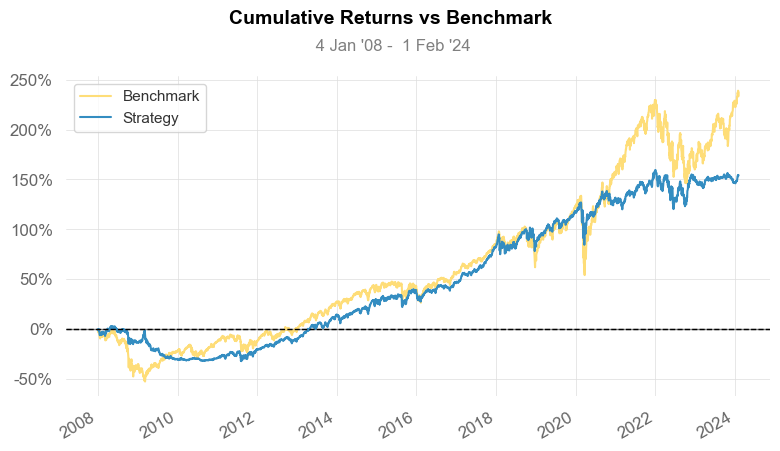

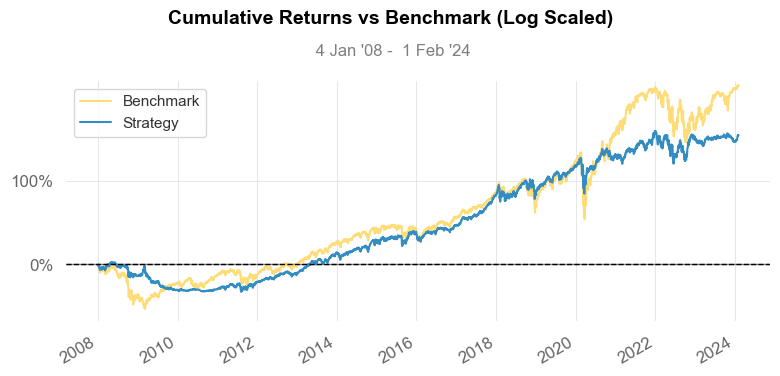

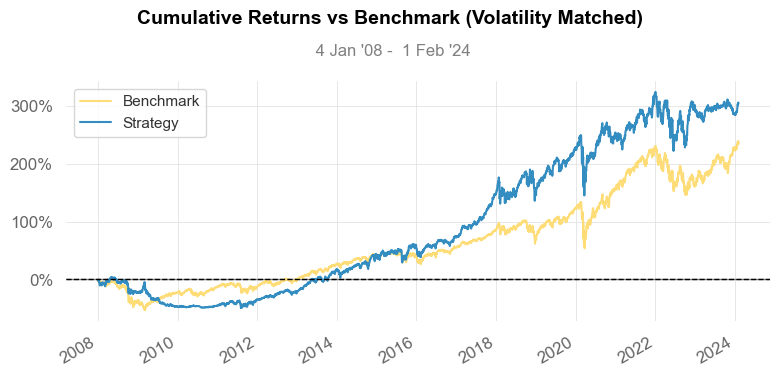

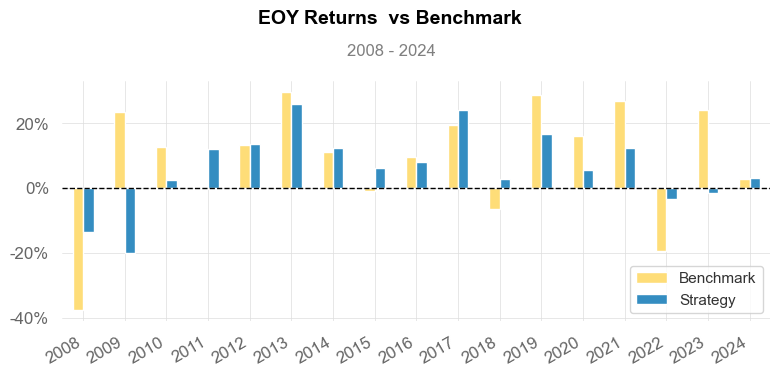

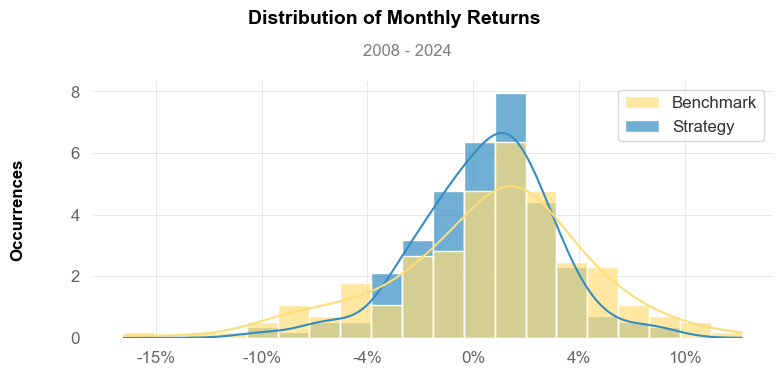

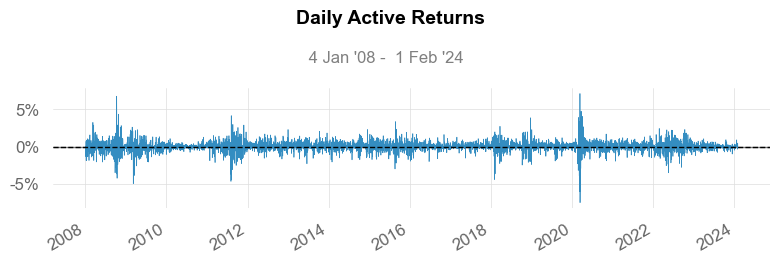

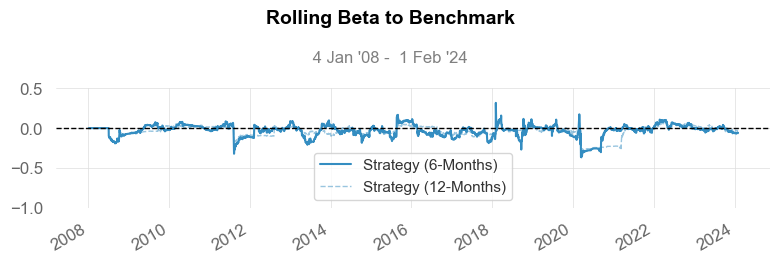

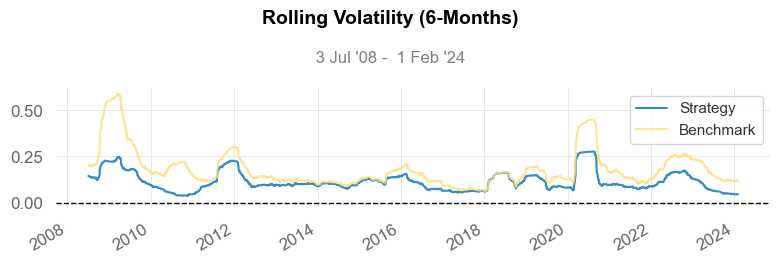

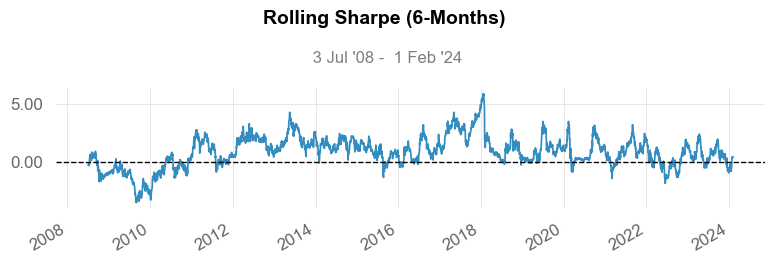

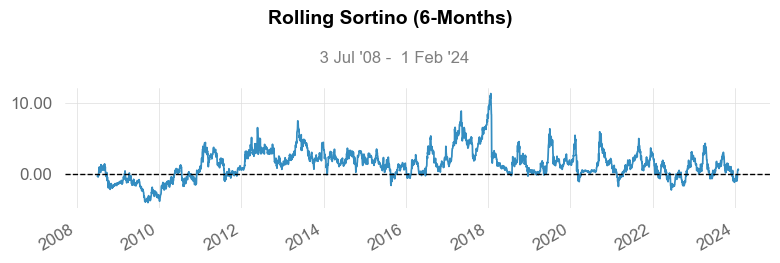

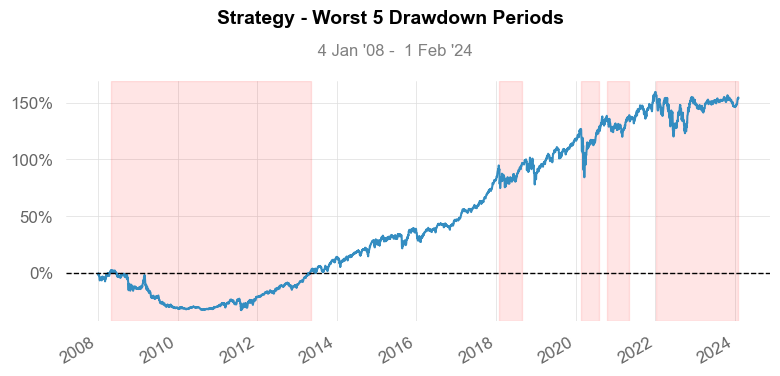

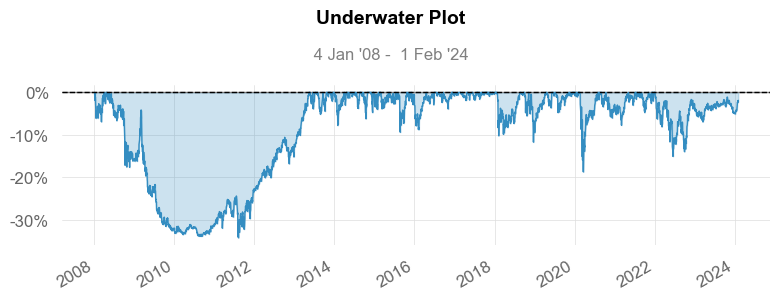

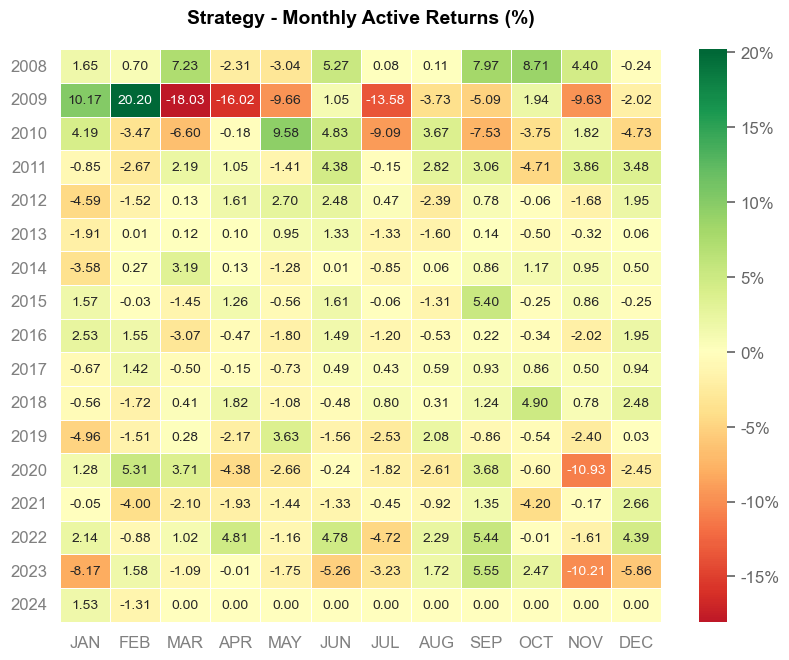

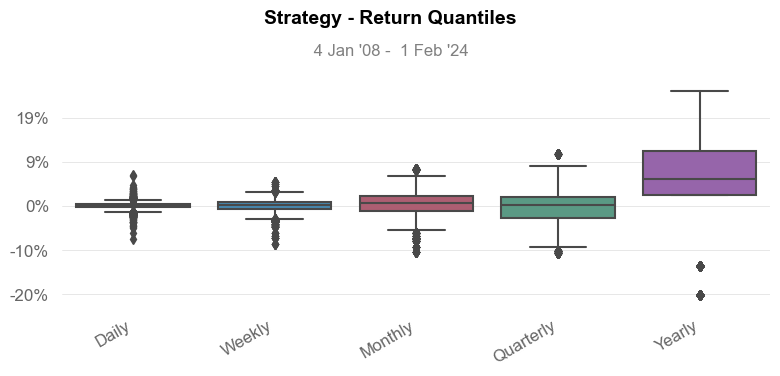

In [1198]:
qs.reports.full(tsmom, 'SPY')